In [9]:
import numpy as np
import pandas as pd 
from datetime import datetime
import os
import operator
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import word_tokenize, pos_tag

from tqdm import tqdm
tqdm.pandas()
import string
from wordcloud import WordCloud, STOPWORDS

from collections import Counter
import matplotlib.pyplot as plt
import gc
gc.enable()
%matplotlib inline

In [ ]:
import plotly
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='ashiquemahmood', api_key='lASBY6kj2hlXCNvSUQko')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

### Loading the data

In [5]:
train = pd.read_csv("data.csv")

In [7]:
train.shape

(1804874, 45)

In [8]:
train.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


## 1.0 How diverse is our hate? 

### Total hate by identity:

In [ ]:
#calculating weighted hate
weighted_hate = train.iloc[:,8:32].multiply(train.iloc[:,1],axis=0).sum().sort_values(ascending=False)
weighted_hate = weighted_hate/weighted_hate.sum()*100

In [ ]:
data = [go.Bar(
            y=weighted_hate.index.tolist(),
            x=weighted_hate.values,
            orientation = 'h',
            marker = {'color':weighted_hate.values,'colorscale':'Viridis'}
            
    )]

layout = go.Layout(
    title='Percentage of Hate for Different Identities',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='identity-hate-percentage')

### Hate over time

In [ ]:
#groups of different identities
religions = ['atheist','christian', 'muslim','jewish','buddhist', 'hindu','other_religion']
race = ['white','black','asian','latino','other_race_or_ethnicity']
gender_sex = ['female', 'male','transgender','homosexual_gay_or_lesbian','heterosexual','bisexual','other_sexual_orientation','other_gender']
disablity = ['psychiatric_or_mental_illness','intellectual_or_learning_disability','physical_disability', 'other_disability']

In [ ]:
def weighted_toxicity_over_time(train,identities):
    '''
    INPUT - train - pandas dataframe with the training data
            identities - list containing identities of interest
    OUTPUT - 
            weighted_toxic - pandas dataframe containing sum of hate each month
    '''
    
    weighted_toxic = train.loc[:,['created_date','target']+identities]
    #normalize
    weighted_toxic.iloc[:,2:] = weighted_toxic.iloc[:,2:]/weighted_toxic.iloc[:,2:].sum()
    #weight by toxicity
    weighted_toxic.iloc[:,2:] = weighted_toxic.iloc[:,2:].multiply(weighted_toxic.iloc[:,1],axis="index")
    # create datetime month
    weighted_toxic['created_month'] = pd.to_datetime(weighted_toxic['created_date']).values.astype('datetime64[M]')
    # #group by month and sum
    weighted_toxic = weighted_toxic.groupby('created_month').sum()
    
    return weighted_toxic

In [ ]:
identities = weighted_hate.index.tolist()
weighted_toxic = weighted_toxicity_over_time(train,identities)

#### By Religion

In [ ]:
weighted_toxic[religions].iplot(title='Toxicity for Different Religions over Time')

#### By Race

In [ ]:
weighted_toxic[race].iplot(title='Toxicity for Different Races over Time')

#### By Gender and Sexual Orientation

In [ ]:
weighted_toxic[gender_sex].iplot(title='Toxicity for Different Genders & Sexual Orientation over Time')

#### By Disability

In [ ]:
weighted_toxic[disablity].iplot(title='Toxicity for Different Disability over Time')

### Correlations

In [ ]:
cols = ['target','severe_toxicity','obscene','identity_attack','insult','threat']
dic = {c:[train[c].corr(train[i]) for i in identities] for c in cols}
correlations = pd.DataFrame.from_dict(dic,columns=identities,orient='index')

In [ ]:
correlations.iplot(kind='heatmap',colorscale='spectral',
                                filename='corrs')

## 2.0 What are the ingredients of toxic comments?

In [ ]:
#some basic features
#comment length
train['com_length'] = train['comment_text'].progress_apply(len)
#no. of unique words
train['num_unique_words'] = train['comment_text'].progress_apply(lambda comment: len(set(comment.split())))
#no. of uppercase words
train['num_uppcase'] = train['comment_text'].progress_apply(lambda x:sum(map(str.isupper,x.split())))
#no. punctuations
train['num_punc'] = train['comment_text'].progress_apply(lambda c: sum(1 for w in c if w in string.punctuation))

In [ ]:
def find_pos(text,pos):
    
    '''
    INPUT - text string input
            pos - the part of speech of interest
    OUTPUT - count - total number of occurence for pos 
    '''
    
    pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
    }
    
    counter = Counter([j for i,j in pos_tag(word_tokenize(text))])
    count = sum(counter[i] for i in pos_family[pos])
    return count

In [ ]:
def mean_pos(data,pos_list):
    '''
    INPUT - data - text data

    OUTPUT - 
            mean_pos - list of mean values of the tags
    '''
    mean_pos = [data.progress_apply(lambda x: find_pos(x,p)).mean() for p in pos_list]
    return mean_pos

In [ ]:
def text_features(data,tags):
    '''
    INPUT - data - text data
            tags - pos tags of interest

    OUTPUT - 
            tuple of text feature labels and values
    '''
    feats = data.iloc[:,-4:].mean()
    mean_tags = mean_pos(data['comment_text'],tags)
    
    return feats.index.tolist()+tags,np.append(feats.values,mean_tags)

In [ ]:
def subset_data(data,feature):
    '''
    INPUT - data - text data
            tags - pos tags of interest

    OUTPUT - 
            tuple of text feature labels and values
    '''
    
    toxic = data[(data['target']>0.5)&(data[feature]>0.5)]
    non_toxic = data[(data['target']==0.0)&(data[feature]>0.5)]
    
    return toxic,non_toxic

In [ ]:
#parts of speech of interest
pos_tags = ['pron','adj','verb']

In [ ]:
#for females
fm_toxic_data,fm_non_toxic_data = subset_data(train,'female')
fm_toxic_feats,fm_toxic_vals = text_features(fm_toxic_data,pos_tags)
fm_non_toxic_feats,fm_non_toxic_vals = text_features(fm_non_toxic_data,pos_tags)

In [ ]:
#muslim
ms_toxic_data, ms_non_toxic_data= subset_data(train,'muslim')
ms_toxic_feats,ms_toxic_vals = text_features(ms_toxic_data,pos_tags)
ms_non_toxic_feats, ms_non_toxic_vals = text_features(ms_non_toxic_data,pos_tags)

In [ ]:
#male
male_toxic_data, male_non_toxic_data= subset_data(train,'male')
male_toxic_feats,male_toxic_vals = text_features(male_toxic_data,pos_tags)
male_non_toxic_feats, male_non_toxic_vals = text_features(male_non_toxic_data,pos_tags)

In [ ]:
#white
white_toxic_data, white_non_toxic_data= subset_data(train,'white')
white_toxic_feats,white_toxic_vals = text_features(white_toxic_data,pos_tags)
white_non_toxic_feats, white_non_toxic_vals = text_features(white_non_toxic_data,pos_tags)

In [ ]:
text_feature_names = white_toxic_feats
text_feat_data = {'Female':[fm_toxic_vals,fm_non_toxic_vals,1, 1],
                 'Male':[male_toxic_vals,male_non_toxic_vals,1, 2],
                 'Muslim':[ms_toxic_vals,ms_non_toxic_vals,2, 1],
                 'White':[white_toxic_vals,white_non_toxic_vals,2,2]}

In [ ]:
fig = plotly.tools.make_subplots(rows=2, cols=2,shared_yaxes=True,subplot_titles=('Female','Male','Muslim','White'))

colors = ['rgb(244, 70, 65)','rgb(65, 244, 97)']
         

for identity,values in text_feat_data.items():
    
    for i,group in enumerate(['Toxic','Non Toxic']):
        
        if identity == 'Male':
            legend = True
        else:
            legend = False
            
        trace = go.Bar(
            x= text_feature_names,
            y= values[i],
            name = group,
            marker = dict(color=colors[i]),
            legendgroup = group,
            showlegend = legend
        )
        
        fig.append_trace(trace,values[-2],values[-1])

fig['layout'].update(height=900, width=900, title='')
fig['layout']['yaxis1'].update(title='mean')


py.iplot(fig, filename='text-feats-groups')

## 3.0 Comments blurring the toxicity line

In [10]:
def word_frequency(data):
    '''
    INPUT - dataframe containing comments
    OUTPUT - pandas series containing word counts 
    '''
    stop = stopwords.words('english')
    data  = data['comment_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    data = data.str.replace('[^\w\s]','')
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    freq = pd.Series(' '.join(data).split()).value_counts()
    return freq

In [54]:
def generate_wc(data,max_words=100,figsize=(20,10),save=None):
    '''
    INPUT - data : dataframe containing comments
            max_words : number of top words to display
            figsize : figure size
            save : file path to save
            
    OUTPUT - plots matplotlib figure and saves figure
    '''
    text = " ".join(data['comment_text'].values)
    wordcloud = WordCloud(max_words=max_words,stopwords=STOPWORDS,background_color='white',width=800, height=400).generate(text)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    if save is not None:
        plt.savefig(save,bbox_inches='tight',dpi=600)
    plt.show()
    

In [11]:
borderline_toxic = train[(train['target']>0.49)&(train['target']<0.51)]
very_toxic = train[(train['target']>0.7)]
non_toxic = train[(train['target']==0)]

In [14]:
bl_frequent_words = word_frequency(borderline_toxic)/borderline_toxic.shape[0]
tx_frequent_words = word_frequency(very_toxic)/very_toxic.shape[0]
ntx_frequent_words = word_frequency(non_toxic)/non_toxic.shape[0]

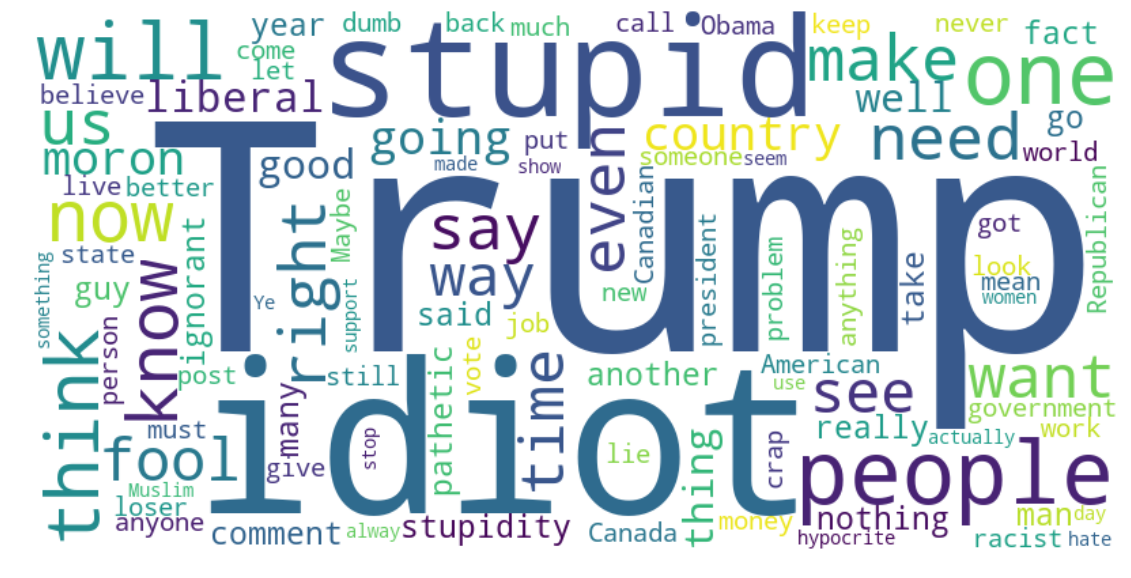

In [55]:
generate_wc(very_toxic,save='toxic.png')

In [15]:
#top eight words in borderline
top = bl_frequent_words[:8].index.tolist()

In [16]:
toxic_top = []
non_toxic_top = []
for word in top:
    toxic_top.append(tx_frequent_words[word])
    non_toxic_top.append(ntx_frequent_words[word])

In [ ]:
trace1 = go.Bar(
    x= top,
    y= bl_frequent_words[:8].values,
    name = 'Borderline'
)

trace2 = go.Bar(
    x= top,
    y= toxic_top,
    name = 'Toxic'
)

trace3 = go.Bar(
    x= top,
    y= non_toxic_top,
    name = 'Non-Toxic'
)

data = [trace1, trace2,trace3]
layout = go.Layout(
    barmode='group',
    title='Top words'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='top-eight')

#### Some examples

In [33]:
borderline_toxic.iloc[3,2]

'“Will Whiteness History Month make all white people hate themselves? Will white students cry themselves to sleep for the rest of their lives?”\n\nHahahahahaha. This makes me very happy. The whole idea sounds a little bit ridiculous but it’s bound to spark some real political hostility! Hoorah for PCC.'

In [43]:
very_toxic.iloc[2,2]

'This bitch is nuts. Who would read a book by a woman.'

In [36]:
non_toxic.iloc[1,2]

"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"